In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        '''Returns the odd and even part'''
        return (self.even(x), self.odd(x))

class Interactor(nn.Module):
    # in_planes input_dim
    def __init__(self, in_planes, splitting=True,
                 kernel = 5, dropout=0.5, groups = 1, hidden_size = 1, INN = True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups
        #输入输出长度等长
        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1 #by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1 #by default: stride==1 

        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1 # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1
        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            #input_dim == in_planes == channels
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups= self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups= self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        #输入 batch_size seq_len feature_dim
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)# B L D
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)

            return (x_even_update, x_odd_update) # B D L 与 Conv1d的输出 N C L对应

        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)

            return (c, d)

class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes = in_planes, splitting=True,
                                kernel = kernel, dropout=dropout, groups = groups, hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update) # B D L

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes= in_planes, kernel = kernel_size, dropout = dropout, groups =groups , hidden_size = hidden_size, INN = INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x) # B D L
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

class SCINet_Tree(nn.Module):
    '''
    递归 二叉树的格式
    '''
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level


        self.workingblock = LevelSCINet(
            in_planes = in_planes,
            kernel_size = kernel_size,
            dropout = dropout,
            groups= groups,
            hidden_size = hidden_size,
            INN = INN)


        if current_level!=0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)

    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2) #L, B, D
        #把序列长度维度调到第0维再拼接
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen): #偶 奇 偶 ...
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: #奇数序列<偶数序列 0 1 2
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_,0).permute(1,0,2) #B, L, D        #Conv1d input N C L

    def forward(self, x):
        x_even_update, x_odd_update= self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level ==0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)#输出一条最终序列
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree = SCINet_Tree(
            in_planes = in_planes,
            current_level = num_levels-1,
            kernel_size = kernel_size,
            dropout =dropout ,
            groups = groups,
            hidden_size = hidden_size,
            INN = INN)

    def forward(self, x):

        x= self.SCINet_Tree(x)

        return x

In [4]:
class SCICNet(nn.Module):
    def __init__(self, n_classes=2, input_len=100, input_dim = 3, hid_size = 1,
                 num_levels = 2, groups = 1, kernel = 5, dropout = 0.5):
        super(SCICNet, self).__init__()
        self.input_len = input_len
        self.output_len = n_classes
        self.input_dim = input_dim
        self.num_levels = num_levels
        self.kernel_size = kernel
        self.dropout = dropout
        self.groups = groups
        self.hidden_size = hid_size

        self.features = EncoderTree(
            in_planes=self.input_dim,
            num_levels = self.num_levels,
            kernel_size = self.kernel_size,
            dropout = self.dropout,
            groups = self.groups,
            hidden_size = self.hidden_size,
            INN = True)

        self.channelMixing = nn.Sequential(
            nn.Linear(self.input_dim,1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_len,input_len//4),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(input_len//4,n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        #print("x:",x.shape)
        #输入B L D
        assert self.input_len % (np.power(2, self.num_levels)) == 0 # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        features = self.features(x)+x #B L D 32 96 3
        features = self.channelMixing(features).squeeze()
        #print("features:",features.shape)
        out = self.classifier(features)
        return out

In [5]:
def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"../weights/SCINet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy


def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [11]:
device = torch.device("cuda")
lr = 0.001
epochs=150
loss=nn.CrossEntropyLoss()
net = SCICNet()
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [12]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)

epoch1,loss0.0021,train acc 0.753282,val acc 0.779
epoch2,loss0.0020,train acc 0.786632,val acc 0.787
epoch3,loss0.0019,train acc 0.790480,val acc 0.791
epoch4,loss0.0019,train acc 0.793534,val acc 0.795
epoch5,loss0.0019,train acc 0.794489,val acc 0.795
epoch6,loss0.0019,train acc 0.797998,val acc 0.798
epoch7,loss0.0019,train acc 0.799687,val acc 0.807
epoch8,loss0.0019,train acc 0.805253,val acc 0.814
epoch9,loss0.0019,train acc 0.810077,val acc 0.819
epoch10,loss0.0019,train acc 0.813653,val acc 0.822
epoch11,loss0.0019,train acc 0.818095,val acc 0.831
epoch12,loss0.0018,train acc 0.824615,val acc 0.833
epoch13,loss0.0018,train acc 0.827229,val acc 0.845
epoch14,loss0.0018,train acc 0.833022,val acc 0.853
epoch15,loss0.0018,train acc 0.836708,val acc 0.861
epoch16,loss0.0018,train acc 0.841459,val acc 0.862
epoch17,loss0.0018,train acc 0.844029,val acc 0.862
epoch18,loss0.0018,train acc 0.847810,val acc 0.869
epoch19,loss0.0018,train acc 0.851225,val acc 0.870
epoch20,loss0.0018,tr

KeyboardInterrupt: 

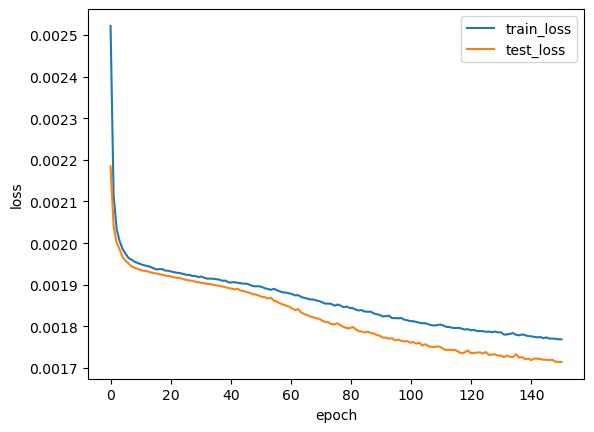

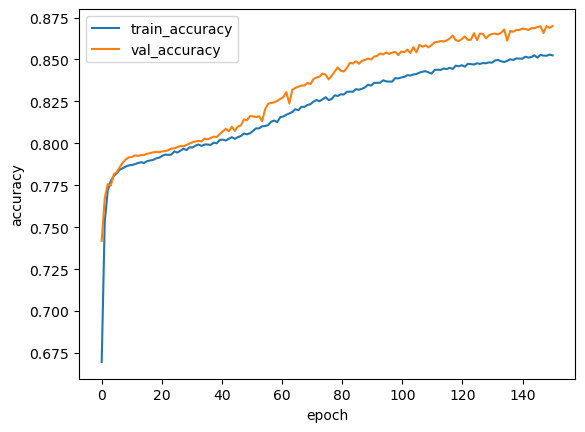

In [13]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [14]:
net.load_state_dict(torch.load("../weights/SCINet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

在测试集上的准确率为:0.892


In [15]:
def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

test precision: 0.8748497221381742  test recall: 0.8591843731369718  test f1_score: 0.8663970086494789
